## QUERY LOCALIZER EXPERIMENT

Целью данного эксперимента является нахождение позы нового изображения на основе уже имеющейся реконструкции SfM. 

# Libraries

In [9]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars

from pathlib import Path
import pycolmap
import sys

sys.path.append("/workspace/pixel-perfect-sfm/")
sys.path.append("/workspace/pixel-perfect-sfm/Hierarchical-Localization")

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from hloc.utils.read_write_model import  write_next_bytes, Point3D, Image, read_images_text, read_points3D_binary,\
        write_points3D_binary, write_images_binary, read_images_binary, write_images_text, read_cameras_binary, \
        Camera, write_cameras_text

from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect

import numpy as np
from matplotlib import pyplot as plt

import open3d as o3d
assert o3d.__version__ == '0.15.2', 'The version 0.15.2 is required!'

# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

В **object_name** необходимо задать имя объекта, над которым вы хотите провести эксперимент.

**check_for_calibrated_images** - булевая переменная, по которой мы выбираем какие поз камер использовать (менее точные (True) или точные (False))

**delete_previous_output** - если True, то удаляет все предыдущие файлы в папке outputs. Использовать супер осторожно.

In [2]:
object_name = 'dragon'

check_for_calibrated_images = False
delete_previous_output = False

**images_all** - путь к папке со всеми изображениями

**outputs** - путь к папке со всеми результатами

**cache_init** - путь к кэш-файлу, его мы получаем во время того, когда делаем KA или BA. В этот файле хранятся featuremaps после  dense feature extraction. В среднем на одну картинку размером 2368х1952 уходит 3 минуты. Этот файл вообще нельзя трогать, поэтому мы копируем его в папку outputs для своего эксперимента и продолжаем работу.

**cache_path** - тот же файл, что cache_init, с которым мы теперь будем работать во время эксперимента.

**sfm_pairs** - файл с названиями пар изображений на каждой строке

**features** - файл с features для каждой картинки, извлеченными при помощи feature_conf

**matches** - файл с matches для каждой пары картинок, извлеченными при помощи matcher_conf

**pairs-loc.txt** - файл с названиями пар изображений на каждой строке (только на этот раз идут пары для картинок из ДБ со всеми возможными картинками из папки query)

In [15]:
root = Path('/workspace')

images_all = root / f'datasets/sk3d/dataset/{object_name}/tis_right/rgb/undistorted/ambient@best'

outputs = root / (f'pixel-perfect-sfm/outputs/{object_name}/localization')

if delete_previous_output:
    !rm -rf $outputs
    
outputs.mkdir(parents=True, exist_ok=True)

sfm_pairs = outputs / 'pairs-sfm.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
loc_pairs = outputs / 'pairs-loc.txt'

exp_loc = outputs / "localizer"
exp_loc.mkdir(parents=True, exist_ok=True)

In [ ]:
cache_init = root / f'pixel-perfect-sfm/outputs/caches/{object_name}/s2dnet_featuremaps_sparse.h5'
!cp -r $cache_init $outputs
cache_path = outputs / 's2dnet_featuremaps_sparse.h5'

# 3D mapping and refinement

Здесь описаны возможности для настройки [**extract_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/extract_features.py#L21)

Здесь описаны возможности для настройки [**match_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/match_features.py#L17)

Здесь описан пайплайн того, как можно использовать свои кастомные [**local features**, **matcher**, **image retrieval**](https://github.com/cvg/Hierarchical-Localization/tree/91f40bfd765add3b59ba7376f8579d8829f7fa78#using-your-own-local-features-or-matcher).


In [16]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Create db and query images

Создаем две папки: mapping и query. В папке mapping будут лежать все те картинки, которые нужны нам для построения реконструкции.  В папке query будут находиться все те картинки, для которых мы хотим новую позы.

In [17]:
import shutil

images = root / f'pixel-perfect-sfm/dataset/{object_name}_loc'
images.mkdir(parents=True, exist_ok=True)

images_references = root / f'pixel-perfect-sfm/dataset/{object_name}_loc/mapping'
images_references.mkdir(parents=True, exist_ok=True)
ref_num = 3

images_queries = root / f'pixel-perfect-sfm/dataset/{object_name}_loc/query'
images_queries.mkdir(parents=True, exist_ok=True)

img_list = sorted([str(p) for p in images_all.iterdir()])
for fn in img_list[:ref_num]: shutil.copy(fn, str(images_references)) 
for fn in img_list[ref_num:100]: shutil.copy(fn, str(images_queries)) 
    
!echo "All image references: " && ls $images_references
!echo "All image queries: " && ls $images_queries

All image references: 
0000.png  0001.png  0002.png
All image queries: 
0003.png  0016.png  0029.png  0042.png	0055.png  0068.png  0081.png  0094.png
0004.png  0017.png  0030.png  0043.png	0056.png  0069.png  0082.png  0095.png
0005.png  0018.png  0031.png  0044.png	0057.png  0070.png  0083.png  0096.png
0006.png  0019.png  0032.png  0045.png	0058.png  0071.png  0084.png  0097.png
0007.png  0020.png  0033.png  0046.png	0059.png  0072.png  0085.png  0098.png
0008.png  0021.png  0034.png  0047.png	0060.png  0073.png  0086.png  0099.png
0009.png  0022.png  0035.png  0048.png	0061.png  0074.png  0087.png
0010.png  0023.png  0036.png  0049.png	0062.png  0075.png  0088.png
0011.png  0024.png  0037.png  0050.png	0063.png  0076.png  0089.png
0012.png  0025.png  0038.png  0051.png	0064.png  0077.png  0090.png
0013.png  0026.png  0039.png  0052.png	0065.png  0078.png  0091.png
0014.png  0027.png  0040.png  0053.png	0066.png  0079.png  0092.png
0015.png  0028.png  0041.png  0054.png	0067.png  008

Здесь мы проверяем какие изображения мы будем использовать для построения реконструкции SfM.

['0000.png', '0001.png', '0002.png']
3 mapping images


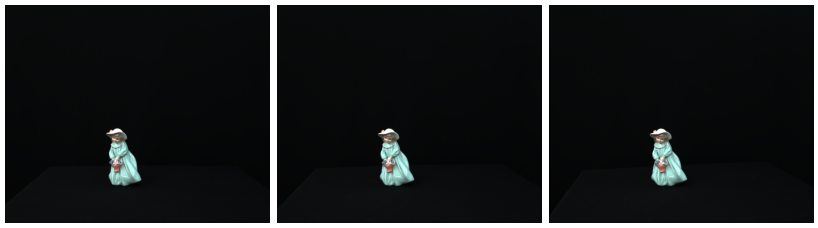

In [18]:
references = [str(p.relative_to(images_references)) for p in images_references.iterdir()]
print(references)
print(len(references), "mapping images")
plot_images([read_image(images_references / r) for r in references[:ref_num]], dpi=50)

**extract_features** - данная функция получает на вход *feature_conf*, *images* (путь к папке с изображениями), *image_list* (список тех изображений, которые вы хотите использовать для feature exctraction), *feature_path* (путь к файлу, где будет сохранен результат). На выходе получаем файл (**features**) с извлеченными features. Если **features** существует, то пропускается.

**pairs_from_exhaustive** - данная функция получает на вход *sfm_pairs* (путь к файлу, где будет сохранен результат), *image_list* (список тех изображений, при помощи которых вы сделаете exhaustive pairs.) На выходе получаем файл (**sfm_pairs**) с парами изображений.  Если **sfm_pairs** существует, то пропускается.

**match_features** - данная функция получает на вход *matcher_conf*, *sfm_pairs* (путь к файлу, где хранятся пары изображений после exhaustive pairing), *features* (путь к файлу, где хранятся извлеченный features для каждого изображения), *matches* (путь к файлу, где хранятся matches для каждой пары изображения). На выходе получаем файл (**matches**) с matches для каждой пары изображений . Если **match_features** существует, то пропускается.


In [20]:
extract_features.main(feature_conf, 
                      images_all, 
                      image_list=references, 
                      feature_path=features)

pairs_from_exhaustive.main(sfm_pairs, 
                           image_list=references)

match_features.main(matcher_conf, 
                    sfm_pairs, 
                    features=features, 
                    matches=matches);

[2022/09/09 09:22:54 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/09/09 09:22:54 hloc INFO] Skipping the extraction.
[2022/09/09 09:22:54 hloc INFO] Found 3 pairs.
[2022/09/09 09:22:54 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/09/09 09:22:55 hloc INFO] Skipping the matching.


После того как мы получили features и matches для картинок из папки mapping, мы можем приступить к построению реконструкции при помощи PixSfM. 

Здесь описано как можно настроить конфигурацию для КА и ВА. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

In [3]:
# run pixsfm

conf = {
        "dense_features": {
                "use_cache": False,
#                 "sparse" : True,
#                 "dtype" : "half",
#                 "overwrite_cache": True,
#                 "load_cache_on_init": False,
#                 "patch_size": 8,
#                 "cache_format": "chunked"
        },
         "KA": {
                "dense_features": {'use_cache': True}, 
                "split_in_subproblems": True,
                "max_kps_per_problem": 1000,  
            },
        
        "BA": { 
            "apply": True
        }
}


# Here we can configure how many and what kind of camera 
# we want to use for reconstruction

opts = dict(camera_model='PINHOLE')
hloc_args = dict(camera_mode=pycolmap.CameraMode.SINGLE,
                #verbose=True,
                image_options=opts)


sfm = PixSfM(conf)
model, sfm_outputs = sfm.reconstruction(exp_loc, 
                                          images_all, 
                                          sfm_pairs, 
                                          features, 
                                          matches, 
                                          image_list=references, 
                                          **hloc_args)

# here model is pycolmap.Reconstruction object
print(model.summary())

NameError: name 'pycolmap' is not defined

Перевод модели в формат TXT.

In [23]:
!mkdir -p $exp_loc/hloc/model_txt/ 

!colmap model_converter \
    --input_path $exp_loc/hloc/ \
    --output_path $exp_loc/hloc/model_txt/ \
    --output_type TXT

## Localization

Здесь мы можем проверить для каких изображений мы хотим найти новые позы.

97  queries images
['0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '0083.png', '0084.pn

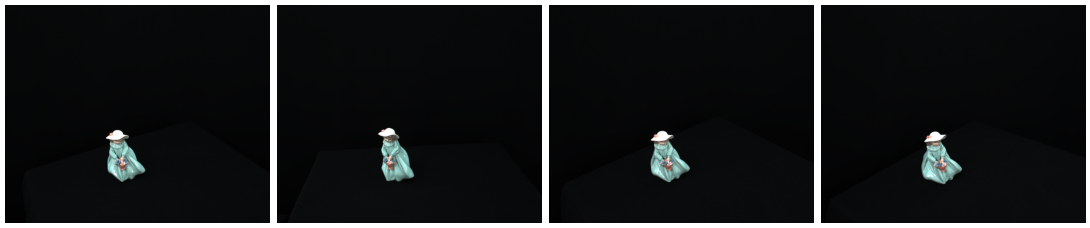

In [24]:
queries = [str(p.relative_to(images_queries)) for p in images_queries.iterdir()]
print(len(queries), " queries images")
print(sorted(queries))
plot_images([read_image(images_queries / r) for r in queries[:4]], dpi=50)

**features_query** - файл с features для каждой картинки из папки query, извлеченными при помощи feature_conf

**matches_query** - файл с matches для каждой пары картинок (mapping -> query), извлеченными при помощи matcher_conf

In [25]:
features_query = outputs / 'features_query.h5'
matches_query = outputs / 'matches_query.h5'

references_registered = [model.images[i].name for i in model.reg_image_ids()]

extract_features.main(feature_conf, 
                      images_all, 
                      image_list=queries, 
                      feature_path=features_query)

pairs_from_exhaustive.main(loc_pairs, 
                           image_list=queries, 
                           ref_list=references_registered)

match_features.main(matcher_conf, 
                    loc_pairs, 
                    features=features_query, 
                    matches=matches_query, 
                    features_ref=features);

[2022/09/09 10:11:22 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/97 [00:00<?, ?it/s]

[2022/09/09 10:13:50 hloc INFO] Finished exporting features.
[2022/09/09 10:13:50 hloc INFO] Found 291 pairs.
[2022/09/09 10:13:50 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/291 [00:00<?, ?it/s]

[2022/09/09 10:55:25 hloc INFO] Finished exporting matches.


На данном этапе мы создаем объект QueryLocalizer, который принимает *model* (pycolmap.Reconstruction объект, модель, на основе которой мы будем находить новые позы для изображений), *conf* (конфиг для query localizer), *dense_features* (dense features из SfM реконструкции).

Здесь описано как можно настроить конфигурацию для query localization. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

In [14]:
import pycolmap
from pixsfm.localize import QueryLocalizer, pose_from_cluster

loc_conf = {
        "dense_features": sfm.conf.dense_features,  # same features as the SfM refinement
        "PnP": {  # initial pose estimation with PnP+RANSAC
            'estimation': {'ransac': {'max_error': 12.0}},
            'refinement': {'refine_focal_length': False, 
                           'refine_extra_params': False},
        },
        "QBA": {  # query pose refinement
            "optimizer:": {'refine_focal_length': False, 
                           'refine_extra_params': False},
        }
    }


dense_features = sfm_outputs["feature_manager"]


# localizer computes references for the entire reconstruction at init
# Parameters:
# - config: Union[dict,DictConfig]: config of localization (use {} for default)
# - reconstruction: pycolmap.Reconstruction; reference COLMAP reconstruction
# - feature_manager: features of reference reconstruction

localizer = QueryLocalizer(model, 
                           conf=loc_conf, 
                           dense_features=dense_features)

[2022/09/07 03:25:50 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/09/07 03:25:50 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


[2022/09/07 03:25:50 pixsfm INFO] Extracting references.


100%[████████████████████] 125/125 [00:00, 20833.3it/s]


[2022/09/07 03:25:50 pixsfm INFO] Reference Extraction Time: 0.008161s


Объявляем какие параметры камеры мы хотим использовать для того чтобы локализовать query ихображение. Тут я использую камеру с теми же параметрами, которые использовались для построения SfM на основе изображений из папки mapping.

In [ ]:
_cams = read_cameras_binary(str(exp_loc / 'hloc/cameras.bin'))
cam_info = _cams[1]
print(_cams[1])

pinhole_camera = pycolmap.Camera(
                            model='PINHOLE',
                            width=cam_info.width,
                            height=cam_info.height,
                            params=cam_info.params)
    
print("Camera info --> ", camera)

Находим позы для всех query изображений.

In [33]:
result_dict = {}
extra_dict = {}

ref_ids = [model.find_image_with_name(r).image_id for r in references_registered]

for k, query in enumerate(sorted(queries)):
    print(f'Current query image --> {query}')


    ret, log = pose_from_cluster(localizer, 
                                 query, 
                                 pinhole_camera, 
                                 ref_ids, 
                                 features, 
                                 matches, 
                                 image_path=images_all / query)    
    
    print("ret --> ", ret['qvec'], ret['tvec'], ret['camera'])

    image_id = int(Path(query).stem) + 1
    
    result_dict[image_id] = Image(
                id=image_id, 
                qvec=ret['qvec'], 
                tvec=ret['tvec'],
                camera_id=cam_info.id, 
                name=query,
                xys= np.array([]), 
                point3D_ids= np.array([]),
    )
    
    extra_dict.update({
        'id': int(Path(query).stem) + 1,
        'qvec': ret['qvec'],
        'tvec': ret['tvec'],
        'camera': ret['camera'],
    })
    


[2022/09/07 04:20:44 pixsfm INFO] Start features exctraction.


Camera(id=1, model='PINHOLE', width=2368, height=1952, params=array([2299.32285848, 2802.61797703, 1184.        ,  976.        ]))
Current query image --> 0003.png
None True


[2022/09/07 04:24:30 pixsfm INFO] Get references for this query.
[2022/09/07 04:24:30 pixsfm INFO] Run QKA


[2022/09/07 04:24:30 pixsfm INFO] QKA Time: 0.0695002s, cost change: 0.0433009 --> 0.0256154


[2022/09/07 04:24:30 pixsfm INFO] Running PnP with 120 correspondences.
[2022/09/07 04:24:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:24:30 pixsfm INFO]  Run QBA


[2022/09/07 04:24:30 pixsfm INFO] QBA Time: 0.242452s, cost change: 0.0224446 --> 0.0222765


[2022/09/07 04:24:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:24:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99511735 -0.00667953 -0.09736748 -0.01471133] [ 6.64518876 -0.98357847  2.0348548 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0004.png
None True


[2022/09/07 04:28:16 pixsfm INFO] Get references for this query.
[2022/09/07 04:28:16 pixsfm INFO] Run QKA


[2022/09/07 04:28:16 pixsfm INFO] QKA Time: 0.075335s, cost change: 0.0439754 --> 0.0291798


[2022/09/07 04:28:16 pixsfm INFO] Running PnP with 108 correspondences.
[2022/09/07 04:28:16 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:28:16 pixsfm INFO]  Run QBA


[2022/09/07 04:28:17 pixsfm INFO] QBA Time: 0.101791s, cost change: 0.0233002 --> 0.0232412


[2022/09/07 04:28:17 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:28:17 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98384469  0.00898839 -0.17815207 -0.01518796] [16.34378526  0.74642252  4.13795833] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0005.png
None True


[2022/09/07 04:31:59 pixsfm INFO] Get references for this query.
[2022/09/07 04:31:59 pixsfm INFO] Run QKA


[2022/09/07 04:31:59 pixsfm INFO] QKA Time: 0.0322199s, cost change: 0.0486637 --> 0.0342755


[2022/09/07 04:31:59 pixsfm INFO] Running PnP with 106 correspondences.
[2022/09/07 04:31:59 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:31:59 pixsfm INFO]  Run QBA


[2022/09/07 04:31:59 pixsfm INFO] QBA Time: 0.133404s, cost change: 0.0234028 --> 0.0230512


[2022/09/07 04:31:59 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:31:59 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98266822 -0.00499985 -0.18423291 -0.01991008] [17.07478115 -0.98663216  4.61976554] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0006.png
None True


[2022/09/07 04:35:46 pixsfm INFO] Get references for this query.
[2022/09/07 04:35:46 pixsfm INFO] Run QKA


[2022/09/07 04:35:47 pixsfm INFO] QKA Time: 0.10937s, cost change: 0.0512726 --> 0.0368732


[2022/09/07 04:35:47 pixsfm INFO] Running PnP with 112 correspondences.
[2022/09/07 04:35:47 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:35:47 pixsfm INFO]  Run QBA


[2022/09/07 04:35:47 pixsfm INFO] QBA Time: 0.262578s, cost change: 0.0239569 --> 0.0238025


[2022/09/07 04:35:47 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:35:47 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97418368 -0.00318706 -0.22467048 -0.02189003] [21.80298388 -0.89508325  6.4189498 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0007.png
None True


[2022/09/07 04:39:34 pixsfm INFO] Get references for this query.
[2022/09/07 04:39:34 pixsfm INFO] Run QKA


[2022/09/07 04:39:34 pixsfm INFO] QKA Time: 0.112499s, cost change: 0.0535248 --> 0.0398522


[2022/09/07 04:39:34 pixsfm INFO] Running PnP with 95 correspondences.
[2022/09/07 04:39:34 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:39:34 pixsfm INFO]  Run QBA


[2022/09/07 04:39:35 pixsfm INFO] QBA Time: 0.247273s, cost change: 0.0239304 --> 0.0238853


[2022/09/07 04:39:35 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:39:35 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96360997 -0.00646551 -0.26602275 -0.02541479] [26.44021899 -1.48850801  8.74408742] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0008.png
None True


[2022/09/07 04:43:23 pixsfm INFO] Get references for this query.
[2022/09/07 04:43:23 pixsfm INFO] Run QKA


[2022/09/07 04:43:23 pixsfm INFO] QKA Time: 0.0887201s, cost change: 0.0550851 --> 0.0425041


[2022/09/07 04:43:23 pixsfm INFO] Running PnP with 90 correspondences.
[2022/09/07 04:43:23 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:43:23 pixsfm INFO]  Run QBA


[2022/09/07 04:43:23 pixsfm INFO] QBA Time: 0.151289s, cost change: 0.0244862 --> 0.0243429


[2022/09/07 04:43:23 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:43:23 pixsfm INFO] Start features exctraction.


ret -->  [ 0.951306   -0.00980855 -0.3067619  -0.02859762] [30.82445034 -2.09895229 11.42057092] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0009.png
None True


[2022/09/07 04:47:07 pixsfm INFO] Get references for this query.
[2022/09/07 04:47:07 pixsfm INFO] Run QKA


[2022/09/07 04:47:07 pixsfm INFO] QKA Time: 0.0881059s, cost change: 0.0561027 --> 0.0449551


[2022/09/07 04:47:07 pixsfm INFO] Running PnP with 92 correspondences.
[2022/09/07 04:47:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:47:07 pixsfm INFO]  Run QBA


[2022/09/07 04:47:07 pixsfm INFO] QBA Time: 0.125797s, cost change: 0.0245169 --> 0.0244597


[2022/09/07 04:47:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:47:07 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93883699 -0.01234615 -0.34246576 -0.03390996] [34.55272415 -2.7305163  13.94832457] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0010.png
None True


[2022/09/07 04:50:53 pixsfm INFO] Get references for this query.
[2022/09/07 04:50:53 pixsfm INFO] Run QKA


[2022/09/07 04:50:53 pixsfm INFO] QKA Time: 0.119369s, cost change: 0.0562094 --> 0.0458761


[2022/09/07 04:50:53 pixsfm INFO] Running PnP with 90 correspondences.
[2022/09/07 04:50:53 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:50:53 pixsfm INFO]  Run QBA


[2022/09/07 04:50:54 pixsfm INFO] QBA Time: 0.206891s, cost change: 0.024961 --> 0.0248271


[2022/09/07 04:50:54 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:50:54 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9217459  -0.00391088 -0.38637362 -0.03293354] [39.05259504 -1.9018794  17.40466304] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0011.png
None True


[2022/09/07 04:54:41 pixsfm INFO] Get references for this query.
[2022/09/07 04:54:41 pixsfm INFO] Run QKA


[2022/09/07 04:54:42 pixsfm INFO] QKA Time: 0.113255s, cost change: 0.0563163 --> 0.046827


[2022/09/07 04:54:42 pixsfm INFO] Running PnP with 79 correspondences.
[2022/09/07 04:54:42 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:54:42 pixsfm INFO]  Run QBA


[2022/09/07 04:54:42 pixsfm INFO] QBA Time: 0.15327s, cost change: 0.0252897 --> 0.0251881


[2022/09/07 04:54:42 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.90520227 -0.00501515 -0.42338385 -0.03646654] [42.47313201 -2.27801237 21.12340616] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0012.png


[2022/09/07 04:54:42 pixsfm INFO] Start features exctraction.


None True


[2022/09/07 04:58:25 pixsfm INFO] Get references for this query.
[2022/09/07 04:58:25 pixsfm INFO] Run QKA


[2022/09/07 04:58:25 pixsfm INFO] QKA Time: 0.093163s, cost change: 0.0556627 --> 0.0463409


[2022/09/07 04:58:25 pixsfm INFO] Running PnP with 75 correspondences.
[2022/09/07 04:58:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 04:58:25 pixsfm INFO]  Run QBA


[2022/09/07 04:58:26 pixsfm INFO] QBA Time: 0.194823s, cost change: 0.025176 --> 0.0250055


[2022/09/07 04:58:26 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 04:58:26 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91814865  0.00234818 -0.39308708 -0.04980052] [39.60690209 -1.72860065 19.4574075 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0013.png
None True


[2022/09/07 05:02:14 pixsfm INFO] Get references for this query.
[2022/09/07 05:02:14 pixsfm INFO] Run QKA


[2022/09/07 05:02:14 pixsfm INFO] QKA Time: 0.073509s, cost change: 0.0564054 --> 0.0459245


[2022/09/07 05:02:14 pixsfm INFO] Running PnP with 78 correspondences.
[2022/09/07 05:02:14 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:02:14 pixsfm INFO]  Run QBA


[2022/09/07 05:02:14 pixsfm INFO] QBA Time: 0.18389s, cost change: 0.0257931 --> 0.0256094


[2022/09/07 05:02:14 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:02:14 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90032435  0.02415921 -0.43118368 -0.05397247] [ 4.32613895e+01 -3.16056195e-03  2.09110271e+01] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0014.png
None True


[2022/09/07 05:06:02 pixsfm INFO] Get references for this query.
[2022/09/07 05:06:02 pixsfm INFO] Run QKA


[2022/09/07 05:06:02 pixsfm INFO] QKA Time: 0.0874159s, cost change: 0.0567916 --> 0.0471695


[2022/09/07 05:06:02 pixsfm INFO] Running PnP with 81 correspondences.
[2022/09/07 05:06:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:06:02 pixsfm INFO]  Run QBA


[2022/09/07 05:06:02 pixsfm INFO] QBA Time: 0.17849s, cost change: 0.0256016 --> 0.025318


[2022/09/07 05:06:02 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:06:02 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9191934   0.02275407 -0.38959252 -0.05275809] [39.3846038   0.24448862 16.91319824] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0015.png
None True


[2022/09/07 05:09:48 pixsfm INFO] Get references for this query.
[2022/09/07 05:09:48 pixsfm INFO] Run QKA


[2022/09/07 05:09:49 pixsfm INFO] QKA Time: 0.0935621s, cost change: 0.0565884 --> 0.0460992


[2022/09/07 05:09:49 pixsfm INFO] Running PnP with 86 correspondences.
[2022/09/07 05:09:49 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:09:49 pixsfm INFO]  Run QBA


[2022/09/07 05:09:49 pixsfm INFO] QBA Time: 0.134335s, cost change: 0.0243513 --> 0.0242727


[2022/09/07 05:09:49 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:09:49 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93832026  0.02261612 -0.34209869 -0.04485623] [34.61660705  0.94201107 13.95518481] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0016.png
None True


[2022/09/07 05:13:31 pixsfm INFO] Get references for this query.
[2022/09/07 05:13:31 pixsfm INFO] Run QKA


[2022/09/07 05:13:31 pixsfm INFO] QKA Time: 0.103595s, cost change: 0.0561213 --> 0.0443721


[2022/09/07 05:13:31 pixsfm INFO] Running PnP with 98 correspondences.
[2022/09/07 05:13:31 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:13:31 pixsfm INFO]  Run QBA


[2022/09/07 05:13:32 pixsfm INFO] QBA Time: 0.19463s, cost change: 0.0247068 --> 0.0245154


[2022/09/07 05:13:32 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:13:32 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95228251  0.02059573 -0.30166477 -0.04161982] [30.32037982  1.07267738 11.04749842] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0017.png
None True


[2022/09/07 05:17:18 pixsfm INFO] Get references for this query.
[2022/09/07 05:17:18 pixsfm INFO] Run QKA


[2022/09/07 05:17:18 pixsfm INFO] QKA Time: 0.0890219s, cost change: 0.0543019 --> 0.0398362


[2022/09/07 05:17:18 pixsfm INFO] Running PnP with 102 correspondences.
[2022/09/07 05:17:18 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:17:18 pixsfm INFO]  Run QBA


[2022/09/07 05:17:18 pixsfm INFO] QBA Time: 0.170142s, cost change: 0.0242887 --> 0.0239479


[2022/09/07 05:17:18 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:17:18 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96470143  0.02572238 -0.25963987 -0.03573013] [25.79593706  2.09102989  8.541806  ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0018.png
None True


[2022/09/07 05:21:07 pixsfm INFO] Get references for this query.
[2022/09/07 05:21:07 pixsfm INFO] Run QKA


[2022/09/07 05:21:07 pixsfm INFO] QKA Time: 0.0935059s, cost change: 0.0515462 --> 0.0364031


[2022/09/07 05:21:07 pixsfm INFO] Running PnP with 101 correspondences.
[2022/09/07 05:21:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:21:07 pixsfm INFO]  Run QBA


[2022/09/07 05:21:07 pixsfm INFO] QBA Time: 0.18456s, cost change: 0.0238226 --> 0.0236316


[2022/09/07 05:21:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:21:08 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97521184  0.02567394 -0.21743639 -0.03200221] [20.97672665  2.36487947  6.31664318] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0019.png
None True


[2022/09/07 05:24:53 pixsfm INFO] Get references for this query.
[2022/09/07 05:24:53 pixsfm INFO] Run QKA


[2022/09/07 05:24:54 pixsfm INFO] QKA Time: 0.0763371s, cost change: 0.0487658 --> 0.0352292


[2022/09/07 05:24:54 pixsfm INFO] Running PnP with 112 correspondences.
[2022/09/07 05:24:54 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:24:54 pixsfm INFO]  Run QBA


[2022/09/07 05:24:54 pixsfm INFO] QBA Time: 0.185155s, cost change: 0.0239154 --> 0.0235338


[2022/09/07 05:24:54 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:24:54 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98394509  0.02737125 -0.17414716 -0.02785053] [15.91706614  2.84242854  4.55037328] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0020.png
None True


[2022/09/07 05:28:41 pixsfm INFO] Get references for this query.
[2022/09/07 05:28:41 pixsfm INFO] Run QKA


[2022/09/07 05:28:42 pixsfm INFO] QKA Time: 0.0567532s, cost change: 0.0463282 --> 0.0299451


[2022/09/07 05:28:42 pixsfm INFO] Running PnP with 108 correspondences.
[2022/09/07 05:28:42 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:28:42 pixsfm INFO]  Run QBA


[2022/09/07 05:28:42 pixsfm INFO] QBA Time: 0.231122s, cost change: 0.0233308 --> 0.0232655


[2022/09/07 05:28:42 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:28:42 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99047716  0.02664931 -0.13289308 -0.02417123] [10.98371697  2.93774051  3.03814599] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0021.png
None True


[2022/09/07 05:32:31 pixsfm INFO] Get references for this query.
[2022/09/07 05:32:31 pixsfm INFO] Run QKA


[2022/09/07 05:32:31 pixsfm INFO] QKA Time: 0.0573599s, cost change: 0.0428032 --> 0.0259093


[2022/09/07 05:32:31 pixsfm INFO] Running PnP with 110 correspondences.
[2022/09/07 05:32:32 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:32:32 pixsfm INFO]  Run QBA


[2022/09/07 05:32:32 pixsfm INFO] QBA Time: 0.168097s, cost change: 0.0230025 --> 0.0225726


[2022/09/07 05:32:32 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:32:32 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99147965  0.03821775 -0.12305927 -0.01907672] [9.73726345 4.36898808 2.63764296] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0022.png
None True


[2022/09/07 05:36:19 pixsfm INFO] Get references for this query.
[2022/09/07 05:36:19 pixsfm INFO] Run QKA


[2022/09/07 05:36:19 pixsfm INFO] QKA Time: 0.053591s, cost change: 0.0398375 --> 0.0219401


[2022/09/07 05:36:19 pixsfm INFO] Running PnP with 113 correspondences.
[2022/09/07 05:36:19 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:36:19 pixsfm INFO]  Run QBA


[2022/09/07 05:36:19 pixsfm INFO] QBA Time: 0.193493s, cost change: 0.0229581 --> 0.0227307


[2022/09/07 05:36:19 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:36:19 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9984696   0.02386118 -0.04703836 -0.01662819] [0.50039964 2.84955528 1.45253638] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0023.png
None True


[2022/09/07 05:40:04 pixsfm INFO] Get references for this query.
[2022/09/07 05:40:04 pixsfm INFO] Run QKA


[2022/09/07 05:40:04 pixsfm INFO] QKA Time: 0.0749259s, cost change: 0.0393781 --> 0.0220975


[2022/09/07 05:40:04 pixsfm INFO] Running PnP with 108 correspondences.
[2022/09/07 05:40:04 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:40:04 pixsfm INFO]  Run QBA


[2022/09/07 05:40:05 pixsfm INFO] QBA Time: 0.268935s, cost change: 0.023568 --> 0.0233319


[2022/09/07 05:40:05 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:40:05 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99970274  0.02018398 -0.00287465 -0.01337054] [-4.92282362  2.45913323  1.38403756] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0024.png
None True


[2022/09/07 05:43:52 pixsfm INFO] Get references for this query.
[2022/09/07 05:43:52 pixsfm INFO] Run QKA


[2022/09/07 05:43:52 pixsfm INFO] QKA Time: 0.070915s, cost change: 0.0455956 --> 0.0295451


[2022/09/07 05:43:52 pixsfm INFO] Running PnP with 104 correspondences.
[2022/09/07 05:43:52 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:43:52 pixsfm INFO]  Run QBA


[2022/09/07 05:43:52 pixsfm INFO] QBA Time: 0.221262s, cost change: 0.0250477 --> 0.0249296


[2022/09/07 05:43:52 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:43:52 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99854263  0.05321042  0.00324643 -0.0084101 ] [-5.54374372  6.20452986  0.06030347] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0025.png
None True


[2022/09/07 05:47:38 pixsfm INFO] Get references for this query.
[2022/09/07 05:47:38 pixsfm INFO] Run QKA


[2022/09/07 05:47:38 pixsfm INFO] QKA Time: 0.0820119s, cost change: 0.0458054 --> 0.030194


[2022/09/07 05:47:38 pixsfm INFO] Running PnP with 113 correspondences.
[2022/09/07 05:47:38 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:47:38 pixsfm INFO]  Run QBA


[2022/09/07 05:47:38 pixsfm INFO] QBA Time: 0.194519s, cost change: 0.0227528 --> 0.0226397


[2022/09/07 05:47:38 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:47:38 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99460637  0.08243185 -0.06190891 -0.0114209 ] [2.37117272 9.98651305 2.28122062] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0026.png
None True


[2022/09/07 05:51:24 pixsfm INFO] Get references for this query.
[2022/09/07 05:51:24 pixsfm INFO] Run QKA


[2022/09/07 05:51:24 pixsfm INFO] QKA Time: 0.042294s, cost change: 0.0440502 --> 0.0274814


[2022/09/07 05:51:24 pixsfm INFO] Running PnP with 111 correspondences.
[2022/09/07 05:51:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:51:24 pixsfm INFO]  Run QBA


[2022/09/07 05:51:24 pixsfm INFO] QBA Time: 0.304846s, cost change: 0.0224972 --> 0.0223548


[2022/09/07 05:51:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:51:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98996893  0.0894407  -0.10774517 -0.0187844 ] [ 8.02411441 10.6629504   2.80818534] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0027.png
None True


[2022/09/07 05:55:10 pixsfm INFO] Get references for this query.
[2022/09/07 05:55:10 pixsfm INFO] Run QKA


[2022/09/07 05:55:10 pixsfm INFO] QKA Time: 0.06673s, cost change: 0.0469045 --> 0.0321753


[2022/09/07 05:55:10 pixsfm INFO] Running PnP with 121 correspondences.
[2022/09/07 05:55:10 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:55:10 pixsfm INFO]  Run QBA


[2022/09/07 05:55:10 pixsfm INFO] QBA Time: 0.175102s, cost change: 0.0242014 --> 0.0240304


[2022/09/07 05:55:10 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:55:10 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99330074  0.06199681 -0.09367316 -0.02711789] [6.24905527 7.41480182 3.01422518] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0028.png
None True


[2022/09/07 05:58:53 pixsfm INFO] Get references for this query.
[2022/09/07 05:58:53 pixsfm INFO] Run QKA


[2022/09/07 05:58:53 pixsfm INFO] QKA Time: 0.0692389s, cost change: 0.0485773 --> 0.0327562


[2022/09/07 05:58:53 pixsfm INFO] Running PnP with 107 correspondences.
[2022/09/07 05:58:53 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 05:58:53 pixsfm INFO]  Run QBA


[2022/09/07 05:58:54 pixsfm INFO] QBA Time: 0.226314s, cost change: 0.0241303 --> 0.0240397


[2022/09/07 05:58:54 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 05:58:54 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98779884  0.04919069 -0.14345891 -0.03540151] [12.19762879  5.46431383  3.73834676] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0029.png
None True


[2022/09/07 06:02:40 pixsfm INFO] Get references for this query.
[2022/09/07 06:02:40 pixsfm INFO] Run QKA


[2022/09/07 06:02:40 pixsfm INFO] QKA Time: 0.0959349s, cost change: 0.0504662 --> 0.0365469


[2022/09/07 06:02:40 pixsfm INFO] Running PnP with 98 correspondences.
[2022/09/07 06:02:40 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:02:40 pixsfm INFO]  Run QBA


[2022/09/07 06:02:41 pixsfm INFO] QBA Time: 0.208489s, cost change: 0.0244971 --> 0.0242547


[2022/09/07 06:02:41 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:02:41 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98081328  0.059448   -0.18177401 -0.03780809] [16.87687887  6.57768612  5.60864021] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0030.png
None True


[2022/09/07 06:06:27 pixsfm INFO] Get references for this query.
[2022/09/07 06:06:27 pixsfm INFO] Run QKA


[2022/09/07 06:06:27 pixsfm INFO] QKA Time: 0.0822659s, cost change: 0.0533235 --> 0.0392162


[2022/09/07 06:06:27 pixsfm INFO] Running PnP with 99 correspondences.
[2022/09/07 06:06:27 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:06:27 pixsfm INFO]  Run QBA


[2022/09/07 06:06:27 pixsfm INFO] QBA Time: 0.170645s, cost change: 0.0245189 --> 0.024381


[2022/09/07 06:06:27 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:06:27 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9706214   0.05447028 -0.22990588 -0.04550135] [22.44046226  5.44914387  7.14403319] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0031.png
None True


[2022/09/07 06:10:13 pixsfm INFO] Get references for this query.
[2022/09/07 06:10:13 pixsfm INFO] Run QKA


[2022/09/07 06:10:13 pixsfm INFO] QKA Time: 0.124023s, cost change: 0.0554659 --> 0.0422738


[2022/09/07 06:10:13 pixsfm INFO] Running PnP with 104 correspondences.
[2022/09/07 06:10:13 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:10:13 pixsfm INFO]  Run QBA


[2022/09/07 06:10:13 pixsfm INFO] QBA Time: 0.139165s, cost change: 0.0249004 --> 0.0245341


[2022/09/07 06:10:13 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:10:13 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96026658  0.05601219 -0.26906918 -0.04850256] [26.93491307  5.34421064  9.79134652] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0032.png
None True


[2022/09/07 06:13:56 pixsfm INFO] Get references for this query.
[2022/09/07 06:13:56 pixsfm INFO] Run QKA


[2022/09/07 06:13:56 pixsfm INFO] QKA Time: 0.0431352s, cost change: 0.0571267 --> 0.0445357


[2022/09/07 06:13:56 pixsfm INFO] Running PnP with 98 correspondences.
[2022/09/07 06:13:56 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:13:56 pixsfm INFO]  Run QBA


[2022/09/07 06:13:56 pixsfm INFO] QBA Time: 0.133317s, cost change: 0.0248571 --> 0.0246065


[2022/09/07 06:13:56 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:13:56 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94693965  0.05133646 -0.31237187 -0.05562094] [31.58039942  4.18888005 12.36276633] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0033.png
None True


[2022/09/07 06:17:44 pixsfm INFO] Get references for this query.
[2022/09/07 06:17:44 pixsfm INFO] Run QKA


[2022/09/07 06:17:44 pixsfm INFO] QKA Time: 0.0314839s, cost change: 0.0580676 --> 0.0470487


[2022/09/07 06:17:44 pixsfm INFO] Running PnP with 89 correspondences.
[2022/09/07 06:17:44 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:17:44 pixsfm INFO]  Run QBA


[2022/09/07 06:17:44 pixsfm INFO] QBA Time: 0.10915s, cost change: 0.0251085 --> 0.024542


[2022/09/07 06:17:44 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:17:44 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94356662  0.0645843  -0.31819928 -0.06526964] [32.43541506  5.43559313 13.19230768] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0034.png
None True


[2022/09/07 06:21:34 pixsfm INFO] Get references for this query.
[2022/09/07 06:21:34 pixsfm INFO] Run QKA


[2022/09/07 06:21:34 pixsfm INFO] QKA Time: 0.0516012s, cost change: 0.0578914 --> 0.0472547


[2022/09/07 06:21:34 pixsfm INFO] Running PnP with 84 correspondences.
[2022/09/07 06:21:34 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:21:34 pixsfm INFO]  Run QBA


[2022/09/07 06:21:34 pixsfm INFO] QBA Time: 0.187729s, cost change: 0.0254953 --> 0.0248307


[2022/09/07 06:21:34 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:21:34 pixsfm INFO] Start features exctraction.


ret -->  [ 0.918971    0.09319967 -0.37701917 -0.06828377] [38.71166243  7.79736397 16.75857883] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0035.png
None True


[2022/09/07 06:25:24 pixsfm INFO] Get references for this query.
[2022/09/07 06:25:24 pixsfm INFO] Run QKA


[2022/09/07 06:25:24 pixsfm INFO] QKA Time: 0.050282s, cost change: 0.056791 --> 0.0466954


[2022/09/07 06:25:24 pixsfm INFO] Running PnP with 73 correspondences.
[2022/09/07 06:25:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:25:24 pixsfm INFO]  Run QBA


[2022/09/07 06:25:24 pixsfm INFO] QBA Time: 0.105156s, cost change: 0.0255275 --> 0.0247079


[2022/09/07 06:25:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:25:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89348571  0.06246282 -0.43845494 -0.0744241 ] [44.12385893  3.32795898 22.80368617] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0036.png
None True


[2022/09/07 06:29:12 pixsfm INFO] Get references for this query.
[2022/09/07 06:29:12 pixsfm INFO] Run QKA


[2022/09/07 06:29:12 pixsfm INFO] QKA Time: 0.0427639s, cost change: 0.0578373 --> 0.0485664


[2022/09/07 06:29:12 pixsfm INFO] Running PnP with 73 correspondences.
[2022/09/07 06:29:12 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:29:12 pixsfm INFO]  Run QBA


[2022/09/07 06:29:12 pixsfm INFO] QBA Time: 0.0938809s, cost change: 0.0258862 --> 0.025642


[2022/09/07 06:29:12 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:29:12 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91738442  0.13776683 -0.36260618 -0.08912289] [37.9229054  12.44706652 17.37054304] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0037.png
None True


[2022/09/07 06:33:02 pixsfm INFO] Get references for this query.
[2022/09/07 06:33:02 pixsfm INFO] Run QKA


[2022/09/07 06:33:02 pixsfm INFO] QKA Time: 0.0536919s, cost change: 0.0584758 --> 0.048832


[2022/09/07 06:33:02 pixsfm INFO] Running PnP with 87 correspondences.
[2022/09/07 06:33:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:33:02 pixsfm INFO]  Run QBA


[2022/09/07 06:33:02 pixsfm INFO] QBA Time: 0.0793381s, cost change: 0.0260111 --> 0.0252206


[2022/09/07 06:33:02 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:33:02 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91842142  0.08218295 -0.37600052 -0.09149681] [38.39076984  5.74013572 18.41274   ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0038.png
None True


[2022/09/07 06:36:51 pixsfm INFO] Get references for this query.
[2022/09/07 06:36:51 pixsfm INFO] Run QKA


[2022/09/07 06:36:51 pixsfm INFO] QKA Time: 0.0359209s, cost change: 0.0577799 --> 0.0469882


[2022/09/07 06:36:51 pixsfm INFO] Running PnP with 87 correspondences.
[2022/09/07 06:36:51 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:36:51 pixsfm INFO]  Run QBA


[2022/09/07 06:36:51 pixsfm INFO] QBA Time: 0.0775762s, cost change: 0.0254175 --> 0.0252631


[2022/09/07 06:36:51 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:36:51 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92437782  0.08230114 -0.36398551 -0.07916264] [37.14098117  6.42270628 17.4106603 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0039.png
None True


[2022/09/07 06:40:38 pixsfm INFO] Get references for this query.
[2022/09/07 06:40:38 pixsfm INFO] Run QKA


[2022/09/07 06:40:39 pixsfm INFO] QKA Time: 0.0530941s, cost change: 0.0575247 --> 0.0474706


[2022/09/07 06:40:39 pixsfm INFO] Running PnP with 96 correspondences.
[2022/09/07 06:40:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:40:39 pixsfm INFO]  Run QBA


[2022/09/07 06:40:39 pixsfm INFO] QBA Time: 0.1338s, cost change: 0.0252512 --> 0.024938


[2022/09/07 06:40:39 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:40:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94415779  0.06390001 -0.31385581 -0.07731362] [31.77589214  4.9304578  12.65808545] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0040.png
None True


[2022/09/07 06:44:24 pixsfm INFO] Get references for this query.
[2022/09/07 06:44:24 pixsfm INFO] Run QKA


[2022/09/07 06:44:24 pixsfm INFO] QKA Time: 0.052892s, cost change: 0.0560463 --> 0.0437353


[2022/09/07 06:44:24 pixsfm INFO] Running PnP with 90 correspondences.
[2022/09/07 06:44:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:44:24 pixsfm INFO]  Run QBA


[2022/09/07 06:44:24 pixsfm INFO] QBA Time: 0.138287s, cost change: 0.0250722 --> 0.0249008


[2022/09/07 06:44:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:44:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95261783  0.08799696 -0.28414332 -0.06354824] [28.76179005  8.61914961 11.93121176] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0041.png
None True


[2022/09/07 06:48:11 pixsfm INFO] Get references for this query.
[2022/09/07 06:48:11 pixsfm INFO] Run QKA


[2022/09/07 06:48:11 pixsfm INFO] QKA Time: 0.0565059s, cost change: 0.0555158 --> 0.0429641


[2022/09/07 06:48:11 pixsfm INFO] Running PnP with 101 correspondences.
[2022/09/07 06:48:11 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:48:11 pixsfm INFO]  Run QBA


[2022/09/07 06:48:11 pixsfm INFO] QBA Time: 0.12329s, cost change: 0.0250746 --> 0.0250368


[2022/09/07 06:48:11 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:48:11 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96565187  0.11076338 -0.22650544 -0.06279515] [22.49516355 11.75522306  7.0738506 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0042.png
None True


[2022/09/07 06:51:57 pixsfm INFO] Get references for this query.
[2022/09/07 06:51:57 pixsfm INFO] Run QKA


[2022/09/07 06:51:58 pixsfm INFO] QKA Time: 0.0604401s, cost change: 0.0540879 --> 0.039717


[2022/09/07 06:51:58 pixsfm INFO] Running PnP with 105 correspondences.
[2022/09/07 06:51:58 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:51:58 pixsfm INFO]  Run QBA


[2022/09/07 06:51:58 pixsfm INFO] QBA Time: 0.145434s, cost change: 0.0250638 --> 0.0247434


[2022/09/07 06:51:58 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:51:58 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97462241  0.09083838 -0.19823421 -0.05062348] [18.94301513 10.04340356  7.26871839] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0043.png
None True


[2022/09/07 06:55:47 pixsfm INFO] Get references for this query.
[2022/09/07 06:55:47 pixsfm INFO] Run QKA


[2022/09/07 06:55:47 pixsfm INFO] QKA Time: 0.0342722s, cost change: 0.0508553 --> 0.0370375


[2022/09/07 06:55:47 pixsfm INFO] Running PnP with 108 correspondences.
[2022/09/07 06:55:47 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:55:47 pixsfm INFO]  Run QBA


[2022/09/07 06:55:47 pixsfm INFO] QBA Time: 0.177751s, cost change: 0.0248015 --> 0.0247068


[2022/09/07 06:55:47 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:55:47 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98264664  0.08605079 -0.15752114 -0.04677534] [14.02847288  9.7309384   4.99303511] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0044.png
None True


[2022/09/07 06:59:38 pixsfm INFO] Get references for this query.
[2022/09/07 06:59:38 pixsfm INFO] Run QKA


[2022/09/07 06:59:38 pixsfm INFO] QKA Time: 0.0586891s, cost change: 0.0481615 --> 0.0349199


[2022/09/07 06:59:38 pixsfm INFO] Running PnP with 112 correspondences.
[2022/09/07 06:59:38 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 06:59:38 pixsfm INFO]  Run QBA


[2022/09/07 06:59:38 pixsfm INFO] QBA Time: 0.110772s, cost change: 0.0246486 --> 0.0245504


[2022/09/07 06:59:38 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 06:59:38 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9887516   0.09184892 -0.11206313 -0.03709327] [ 8.58902869 10.86550616  3.93652899] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0045.png
None True


[2022/09/07 07:03:24 pixsfm INFO] Get references for this query.
[2022/09/07 07:03:24 pixsfm INFO] Run QKA


[2022/09/07 07:03:24 pixsfm INFO] QKA Time: 0.048038s, cost change: 0.0495782 --> 0.0333516


[2022/09/07 07:03:24 pixsfm INFO] Running PnP with 106 correspondences.
[2022/09/07 07:03:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:03:24 pixsfm INFO]  Run QBA


[2022/09/07 07:03:24 pixsfm INFO] QBA Time: 0.17615s, cost change: 0.0236517 --> 0.0234401


[2022/09/07 07:03:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:03:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98386359  0.12841377 -0.12192433 -0.02562798] [ 9.83417459 15.27137787  3.99817539] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0046.png
None True


[2022/09/07 07:07:09 pixsfm INFO] Get references for this query.
[2022/09/07 07:07:09 pixsfm INFO] Run QKA


[2022/09/07 07:07:09 pixsfm INFO] QKA Time: 0.0338831s, cost change: 0.0489214 --> 0.0325343


[2022/09/07 07:07:09 pixsfm INFO] Running PnP with 109 correspondences.
[2022/09/07 07:07:09 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:07:09 pixsfm INFO]  Run QBA


[2022/09/07 07:07:09 pixsfm INFO] QBA Time: 0.136019s, cost change: 0.0241158 --> 0.0238393


[2022/09/07 07:07:09 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:07:09 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99179694  0.10905006 -0.06350059 -0.02036136] [ 2.55142522 13.19680677  3.2702916 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0047.png
None True


[2022/09/07 07:10:53 pixsfm INFO] Get references for this query.
[2022/09/07 07:10:53 pixsfm INFO] Run QKA


[2022/09/07 07:10:53 pixsfm INFO] QKA Time: 0.05161s, cost change: 0.0476374 --> 0.0336642


[2022/09/07 07:10:53 pixsfm INFO] Running PnP with 95 correspondences.
[2022/09/07 07:10:53 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:10:53 pixsfm INFO]  Run QBA


[2022/09/07 07:10:53 pixsfm INFO] QBA Time: 0.17682s, cost change: 0.0234539 --> 0.0232721


[2022/09/07 07:10:53 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:10:53 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99155413  0.12563038 -0.03081678 -0.00936736] [-1.45463042 15.31893012  3.16312018] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0048.png
None True


[2022/09/07 07:14:39 pixsfm INFO] Get references for this query.
[2022/09/07 07:14:39 pixsfm INFO] Run QKA


[2022/09/07 07:14:39 pixsfm INFO] QKA Time: 0.043685s, cost change: 0.0502364 --> 0.036076


[2022/09/07 07:14:39 pixsfm INFO] Running PnP with 107 correspondences.
[2022/09/07 07:14:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:14:39 pixsfm INFO]  Run QBA


[2022/09/07 07:14:39 pixsfm INFO] QBA Time: 0.17076s, cost change: 0.0239649 --> 0.0239054


[2022/09/07 07:14:39 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:14:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98626519  0.1635736  -0.02198583 -0.00642494] [-2.57084454 19.99899476  5.09401209] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0049.png
None True


[2022/09/07 07:18:24 pixsfm INFO] Get references for this query.
[2022/09/07 07:18:24 pixsfm INFO] Run QKA


[2022/09/07 07:18:25 pixsfm INFO] QKA Time: 0.041898s, cost change: 0.0502299 --> 0.0370076


[2022/09/07 07:18:25 pixsfm INFO] Running PnP with 104 correspondences.
[2022/09/07 07:18:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:18:25 pixsfm INFO]  Run QBA


[2022/09/07 07:18:25 pixsfm INFO] QBA Time: 0.152716s, cost change: 0.0242108 --> 0.023951


[2022/09/07 07:18:25 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.98382073  0.16795935 -0.05961242 -0.01824243] [ 2.20929068 20.35034003  4.71650087] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0050.png


[2022/09/07 07:18:25 pixsfm INFO] Start features exctraction.


None True


[2022/09/07 07:22:09 pixsfm INFO] Get references for this query.
[2022/09/07 07:22:09 pixsfm INFO] Run QKA


[2022/09/07 07:22:09 pixsfm INFO] QKA Time: 0.0560319s, cost change: 0.0492825 --> 0.0372236


[2022/09/07 07:22:09 pixsfm INFO] Running PnP with 98 correspondences.
[2022/09/07 07:22:09 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:22:09 pixsfm INFO]  Run QBA


[2022/09/07 07:22:09 pixsfm INFO] QBA Time: 0.160025s, cost change: 0.0245355 --> 0.0243099


[2022/09/07 07:22:09 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.97446159  0.19687734 -0.1036646  -0.03029141] [ 7.97577658 23.40733944  4.37211925] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0051.png


[2022/09/07 07:22:09 pixsfm INFO] Start features exctraction.


None True


[2022/09/07 07:25:54 pixsfm INFO] Get references for this query.
[2022/09/07 07:25:54 pixsfm INFO] Run QKA


[2022/09/07 07:25:54 pixsfm INFO] QKA Time: 0.0358119s, cost change: 0.0514544 --> 0.0371438


[2022/09/07 07:25:54 pixsfm INFO] Running PnP with 103 correspondences.
[2022/09/07 07:25:54 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:25:54 pixsfm INFO]  Run QBA


[2022/09/07 07:25:54 pixsfm INFO] QBA Time: 0.167107s, cost change: 0.025654 --> 0.0252839


[2022/09/07 07:25:54 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:25:54 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98110503  0.16657559 -0.09234474 -0.03402852] [ 6.51845857 20.08120001  5.42740031] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0052.png
None True


[2022/09/07 07:29:38 pixsfm INFO] Get references for this query.
[2022/09/07 07:29:38 pixsfm INFO] Run QKA


[2022/09/07 07:29:38 pixsfm INFO] QKA Time: 0.072166s, cost change: 0.0525683 --> 0.0367145


[2022/09/07 07:29:38 pixsfm INFO] Running PnP with 101 correspondences.
[2022/09/07 07:29:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:29:39 pixsfm INFO]  Run QBA


[2022/09/07 07:29:39 pixsfm INFO] QBA Time: 0.103039s, cost change: 0.0245393 --> 0.0242903


[2022/09/07 07:29:39 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:29:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96369143  0.18610915 -0.18521478 -0.04855611] [17.92929813 21.27185423  6.53549856] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0053.png
None True


[2022/09/07 07:33:20 pixsfm INFO] Get references for this query.
[2022/09/07 07:33:20 pixsfm INFO] Run QKA


[2022/09/07 07:33:21 pixsfm INFO] QKA Time: 0.085901s, cost change: 0.052456 --> 0.0406506


[2022/09/07 07:33:21 pixsfm INFO] Running PnP with 100 correspondences.
[2022/09/07 07:33:21 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:33:21 pixsfm INFO]  Run QBA


[2022/09/07 07:33:21 pixsfm INFO] QBA Time: 0.146004s, cost change: 0.0251117 --> 0.0249622


[2022/09/07 07:33:21 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:33:21 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97147184  0.11235369 -0.19858508 -0.06467677] [19.12961894 12.19818966  6.85990117] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0054.png
None True


[2022/09/07 07:37:05 pixsfm INFO] Get references for this query.
[2022/09/07 07:37:05 pixsfm INFO] Run QKA


[2022/09/07 07:37:05 pixsfm INFO] QKA Time: 0.050555s, cost change: 0.0561397 --> 0.0432296


[2022/09/07 07:37:05 pixsfm INFO] Running PnP with 92 correspondences.
[2022/09/07 07:37:05 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:37:05 pixsfm INFO]  Run QBA


[2022/09/07 07:37:05 pixsfm INFO] QBA Time: 0.091795s, cost change: 0.025166 --> 0.0248857


[2022/09/07 07:37:05 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:37:06 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96656586  0.10550408 -0.22226461 -0.07223419] [21.86369697 10.98075512  7.63576904] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0055.png
None True


[2022/09/07 07:40:49 pixsfm INFO] Get references for this query.
[2022/09/07 07:40:49 pixsfm INFO] Run QKA


[2022/09/07 07:40:49 pixsfm INFO] QKA Time: 0.0851021s, cost change: 0.0563045 --> 0.045146


[2022/09/07 07:40:49 pixsfm INFO] Running PnP with 92 correspondences.
[2022/09/07 07:40:49 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:40:49 pixsfm INFO]  Run QBA


[2022/09/07 07:40:49 pixsfm INFO] QBA Time: 0.126237s, cost change: 0.0253809 --> 0.0250511


[2022/09/07 07:40:49 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:40:49 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96019084  0.10706089 -0.24746036 -0.07304026] [24.75996435 11.26492061 12.07460931] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0056.png
None True


[2022/09/07 07:44:29 pixsfm INFO] Get references for this query.
[2022/09/07 07:44:29 pixsfm INFO] Run QKA


[2022/09/07 07:44:29 pixsfm INFO] QKA Time: 0.046639s, cost change: 0.0591932 --> 0.0479247


[2022/09/07 07:44:29 pixsfm INFO] Running PnP with 89 correspondences.
[2022/09/07 07:44:29 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:44:29 pixsfm INFO]  Run QBA


[2022/09/07 07:44:29 pixsfm INFO] QBA Time: 0.129464s, cost change: 0.0257117 --> 0.0254041


[2022/09/07 07:44:29 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:44:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93739767  0.11197256 -0.31840281 -0.08583363] [32.64036812 10.19387984 14.22034722] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0057.png
None True


[2022/09/07 07:48:13 pixsfm INFO] Get references for this query.
[2022/09/07 07:48:13 pixsfm INFO] Run QKA


[2022/09/07 07:48:13 pixsfm INFO] QKA Time: 0.0456111s, cost change: 0.0585294 --> 0.0484217


[2022/09/07 07:48:13 pixsfm INFO] Running PnP with 87 correspondences.
[2022/09/07 07:48:13 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:48:13 pixsfm INFO]  Run QBA


[2022/09/07 07:48:13 pixsfm INFO] QBA Time: 0.11396s, cost change: 0.0257004 --> 0.024787


[2022/09/07 07:48:13 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:48:13 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94125254  0.04339664 -0.32595029 -0.07692067] [32.84006342  2.63031905 15.36671282] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0058.png
None True


[2022/09/07 07:51:59 pixsfm INFO] Get references for this query.
[2022/09/07 07:51:59 pixsfm INFO] Run QKA


[2022/09/07 07:51:59 pixsfm INFO] QKA Time: 0.0616479s, cost change: 0.0576719 --> 0.0477867


[2022/09/07 07:51:59 pixsfm INFO] Running PnP with 79 correspondences.
[2022/09/07 07:51:59 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:51:59 pixsfm INFO]  Run QBA


[2022/09/07 07:52:00 pixsfm INFO] QBA Time: 0.0961599s, cost change: 0.0266287 --> 0.0258031


[2022/09/07 07:52:00 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:52:00 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93927647  0.06948702 -0.31536113 -0.11609753] [31.52224704  4.4955763  15.57674269] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0059.png
None True


[2022/09/07 07:55:41 pixsfm INFO] Get references for this query.
[2022/09/07 07:55:41 pixsfm INFO] Run QKA


[2022/09/07 07:55:41 pixsfm INFO] QKA Time: 0.0500171s, cost change: 0.0570758 --> 0.0485843


[2022/09/07 07:55:41 pixsfm INFO] Running PnP with 78 correspondences.
[2022/09/07 07:55:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:55:41 pixsfm INFO]  Run QBA


[2022/09/07 07:55:41 pixsfm INFO] QBA Time: 0.0943661s, cost change: 0.0257484 --> 0.0256993


[2022/09/07 07:55:41 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:55:41 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88112243  0.18762257 -0.41308907 -0.13333587] [43.25370299 14.86834601 24.50831626] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0060.png
None True


[2022/09/07 07:59:21 pixsfm INFO] Get references for this query.
[2022/09/07 07:59:21 pixsfm INFO] Run QKA


[2022/09/07 07:59:21 pixsfm INFO] QKA Time: 0.0533419s, cost change: 0.0599684 --> 0.0495073


[2022/09/07 07:59:21 pixsfm INFO] Running PnP with 84 correspondences.
[2022/09/07 07:59:21 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 07:59:21 pixsfm INFO]  Run QBA


[2022/09/07 07:59:22 pixsfm INFO] QBA Time: 0.110156s, cost change: 0.0261748 --> 0.0261166


[2022/09/07 07:59:22 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 07:59:22 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93198241  0.10051465 -0.32685882 -0.12028673] [33.18548345  8.10213015 19.64406227] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0061.png
None True


[2022/09/07 08:03:07 pixsfm INFO] Get references for this query.
[2022/09/07 08:03:07 pixsfm INFO] Run QKA


[2022/09/07 08:03:07 pixsfm INFO] QKA Time: 0.0681801s, cost change: 0.0589651 --> 0.0489674


[2022/09/07 08:03:07 pixsfm INFO] Running PnP with 87 correspondences.
[2022/09/07 08:03:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:03:07 pixsfm INFO]  Run QBA


[2022/09/07 08:03:07 pixsfm INFO] QBA Time: 0.124713s, cost change: 0.0260117 --> 0.0256507


[2022/09/07 08:03:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:03:07 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91941642  0.11977298 -0.35710348 -0.11315909] [36.70429725  9.38766004 17.91080123] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0062.png
None True


[2022/09/07 08:06:50 pixsfm INFO] Get references for this query.
[2022/09/07 08:06:50 pixsfm INFO] Run QKA


[2022/09/07 08:06:50 pixsfm INFO] QKA Time: 0.095005s, cost change: 0.0592153 --> 0.0471996


[2022/09/07 08:06:50 pixsfm INFO] Running PnP with 90 correspondences.
[2022/09/07 08:06:50 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:06:50 pixsfm INFO]  Run QBA


[2022/09/07 08:06:50 pixsfm INFO] QBA Time: 0.105532s, cost change: 0.0262012 --> 0.0254959


[2022/09/07 08:06:50 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:06:50 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91237037  0.23895388 -0.31783479 -0.09727488] [34.01073193 23.76245433 14.67790568] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0063.png
None True


[2022/09/07 08:10:30 pixsfm INFO] Get references for this query.
[2022/09/07 08:10:30 pixsfm INFO] Run QKA


[2022/09/07 08:10:30 pixsfm INFO] QKA Time: 0.0619512s, cost change: 0.0568968 --> 0.0454443


[2022/09/07 08:10:30 pixsfm INFO] Running PnP with 96 correspondences.
[2022/09/07 08:10:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:10:30 pixsfm INFO]  Run QBA


[2022/09/07 08:10:30 pixsfm INFO] QBA Time: 0.13857s, cost change: 0.0259535 --> 0.0255401


[2022/09/07 08:10:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:10:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95624552  0.13767417 -0.24050006 -0.09380857] [24.17106272 14.46853161 13.47385799] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0064.png
None True


[2022/09/07 08:14:14 pixsfm INFO] Get references for this query.
[2022/09/07 08:14:14 pixsfm INFO] Run QKA


[2022/09/07 08:14:15 pixsfm INFO] QKA Time: 0.051527s, cost change: 0.0545601 --> 0.0428508


[2022/09/07 08:14:15 pixsfm INFO] Running PnP with 101 correspondences.
[2022/09/07 08:14:15 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:14:15 pixsfm INFO]  Run QBA


[2022/09/07 08:14:15 pixsfm INFO] QBA Time: 0.065001s, cost change: 0.0252771 --> 0.0252466


[2022/09/07 08:14:15 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:14:15 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94477698  0.19744875 -0.24959166 -0.07819496] [25.87497884 21.04591375  9.63614594] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0065.png
None True


[2022/09/07 08:18:02 pixsfm INFO] Get references for this query.
[2022/09/07 08:18:02 pixsfm INFO] Run QKA


[2022/09/07 08:18:02 pixsfm INFO] QKA Time: 0.0597601s, cost change: 0.0543937 --> 0.042271


[2022/09/07 08:18:02 pixsfm INFO] Running PnP with 99 correspondences.
[2022/09/07 08:18:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:18:02 pixsfm INFO]  Run QBA


[2022/09/07 08:18:02 pixsfm INFO] QBA Time: 0.114067s, cost change: 0.0256897 --> 0.0254601


[2022/09/07 08:18:02 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:18:02 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96545475  0.17483513 -0.18422749 -0.05822395] [17.8937763  19.86192466  7.11333922] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0066.png
None True


[2022/09/07 08:21:48 pixsfm INFO] Get references for this query.
[2022/09/07 08:21:48 pixsfm INFO] Run QKA


[2022/09/07 08:21:48 pixsfm INFO] QKA Time: 0.0522768s, cost change: 0.0527463 --> 0.0402065


[2022/09/07 08:21:48 pixsfm INFO] Running PnP with 94 correspondences.
[2022/09/07 08:21:48 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:21:48 pixsfm INFO]  Run QBA


[2022/09/07 08:21:48 pixsfm INFO] QBA Time: 0.111744s, cost change: 0.0248859 --> 0.024506


[2022/09/07 08:21:48 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:21:48 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95788654  0.21958206 -0.17665853 -0.05503509] [17.11490747 25.12840727  7.77189136] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0067.png
None True


[2022/09/07 08:25:30 pixsfm INFO] Get references for this query.
[2022/09/07 08:25:30 pixsfm INFO] Run QKA


[2022/09/07 08:25:30 pixsfm INFO] QKA Time: 0.0400541s, cost change: 0.0507295 --> 0.0377507


[2022/09/07 08:25:30 pixsfm INFO] Running PnP with 91 correspondences.
[2022/09/07 08:25:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:25:30 pixsfm INFO]  Run QBA


[2022/09/07 08:25:30 pixsfm INFO] QBA Time: 0.143753s, cost change: 0.0248152 --> 0.024374


[2022/09/07 08:25:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:25:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96490944  0.22205587 -0.13319809 -0.04358024] [11.72561639 25.98434616  6.81476673] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0068.png
None True


[2022/09/07 08:29:13 pixsfm INFO] Get references for this query.
[2022/09/07 08:29:13 pixsfm INFO] Run QKA


[2022/09/07 08:29:13 pixsfm INFO] QKA Time: 0.0418069s, cost change: 0.0515333 --> 0.0375214


[2022/09/07 08:29:13 pixsfm INFO] Running PnP with 96 correspondences.
[2022/09/07 08:29:13 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:29:13 pixsfm INFO]  Run QBA


[2022/09/07 08:29:13 pixsfm INFO] QBA Time: 0.11613s, cost change: 0.0244748 --> 0.0243344


[2022/09/07 08:29:13 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:29:13 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97356431  0.20424979 -0.09920814 -0.02474461] [ 7.15232599 24.53847173  7.27899264] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0069.png
None True


[2022/09/07 08:32:58 pixsfm INFO] Get references for this query.
[2022/09/07 08:32:58 pixsfm INFO] Run QKA


[2022/09/07 08:32:58 pixsfm INFO] QKA Time: 0.0334921s, cost change: 0.0493099 --> 0.0375396


[2022/09/07 08:32:58 pixsfm INFO] Running PnP with 94 correspondences.
[2022/09/07 08:32:58 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:32:58 pixsfm INFO]  Run QBA


[2022/09/07 08:32:58 pixsfm INFO] QBA Time: 0.0663791s, cost change: 0.0242278 --> 0.0241733


[2022/09/07 08:32:58 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:32:58 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97522244  0.21699121 -0.04004538 -0.01588656] [-5.49089110e-04  2.61309522e+01  4.96547246e+00] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0070.png
None True


[2022/09/07 08:36:41 pixsfm INFO] Get references for this query.
[2022/09/07 08:36:41 pixsfm INFO] Run QKA


[2022/09/07 08:36:41 pixsfm INFO] QKA Time: 0.0424609s, cost change: 0.0507311 --> 0.0380273


[2022/09/07 08:36:41 pixsfm INFO] Running PnP with 88 correspondences.
[2022/09/07 08:36:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:36:41 pixsfm INFO]  Run QBA


[2022/09/07 08:36:41 pixsfm INFO] QBA Time: 0.14711s, cost change: 0.0250039 --> 0.0249364


[2022/09/07 08:36:41 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:36:41 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96826501  0.2477614  -0.02801854 -0.01709153] [-1.56309184 29.84221338  8.87454122] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0071.png
None True


[2022/09/07 08:40:24 pixsfm INFO] Get references for this query.
[2022/09/07 08:40:24 pixsfm INFO] Run QKA


[2022/09/07 08:40:24 pixsfm INFO] QKA Time: 0.038341s, cost change: 0.0511416 --> 0.0389826


[2022/09/07 08:40:24 pixsfm INFO] Running PnP with 87 correspondences.
[2022/09/07 08:40:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:40:24 pixsfm INFO]  Run QBA


[2022/09/07 08:40:25 pixsfm INFO] QBA Time: 0.158811s, cost change: 0.024898 --> 0.0247588


[2022/09/07 08:40:25 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:40:25 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96545194  0.25059861 -0.06587103 -0.02763849] [ 3.2391944  29.94981056  8.76864585] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0072.png
None True


[2022/09/07 08:44:11 pixsfm INFO] Get references for this query.
[2022/09/07 08:44:11 pixsfm INFO] Run QKA


[2022/09/07 08:44:11 pixsfm INFO] QKA Time: 0.0545051s, cost change: 0.0538922 --> 0.0397355


[2022/09/07 08:44:11 pixsfm INFO] Running PnP with 86 correspondences.
[2022/09/07 08:44:11 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:44:11 pixsfm INFO]  Run QBA


[2022/09/07 08:44:11 pixsfm INFO] QBA Time: 0.145224s, cost change: 0.0248052 --> 0.0245579


[2022/09/07 08:44:11 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:44:11 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95839556  0.25743064 -0.11459934 -0.04554571] [ 9.60620586 30.19352442  8.92422569] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0073.png
None True


[2022/09/07 08:47:56 pixsfm INFO] Get references for this query.
[2022/09/07 08:47:56 pixsfm INFO] Run QKA


[2022/09/07 08:47:56 pixsfm INFO] QKA Time: 0.0568032s, cost change: 0.0550476 --> 0.040661


[2022/09/07 08:47:56 pixsfm INFO] Running PnP with 90 correspondences.
[2022/09/07 08:47:56 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:47:56 pixsfm INFO]  Run QBA


[2022/09/07 08:47:56 pixsfm INFO] QBA Time: 0.102038s, cost change: 0.0253207 --> 0.024925


[2022/09/07 08:47:56 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:47:56 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95236804  0.26078935 -0.14751611 -0.0567717 ] [13.86848773 30.08701855  9.03235656] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0074.png
None True


[2022/09/07 08:51:39 pixsfm INFO] Get references for this query.
[2022/09/07 08:51:39 pixsfm INFO] Run QKA


[2022/09/07 08:51:39 pixsfm INFO] QKA Time: 0.073195s, cost change: 0.0546113 --> 0.0415155


[2022/09/07 08:51:39 pixsfm INFO] Running PnP with 88 correspondences.
[2022/09/07 08:51:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:51:39 pixsfm INFO]  Run QBA


[2022/09/07 08:51:39 pixsfm INFO] QBA Time: 0.14238s, cost change: 0.0261738 --> 0.0258648


[2022/09/07 08:51:39 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:51:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9657883   0.19480961 -0.15643999 -0.06948888] [14.73768784 22.40112235  8.65771765] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0075.png
None True


[2022/09/07 08:55:22 pixsfm INFO] Get references for this query.
[2022/09/07 08:55:22 pixsfm INFO] Run QKA


[2022/09/07 08:55:22 pixsfm INFO] QKA Time: 0.0372841s, cost change: 0.0539738 --> 0.0431207


[2022/09/07 08:55:22 pixsfm INFO] Running PnP with 89 correspondences.
[2022/09/07 08:55:22 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:55:22 pixsfm INFO]  Run QBA


[2022/09/07 08:55:22 pixsfm INFO] QBA Time: 0.13326s, cost change: 0.0254946 --> 0.0254148


[2022/09/07 08:55:22 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:55:22 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95784073  0.18934253 -0.20023067 -0.08122947] [19.98884263 20.93634247 10.08477211] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0076.png
None True


[2022/09/07 08:59:06 pixsfm INFO] Get references for this query.
[2022/09/07 08:59:06 pixsfm INFO] Run QKA


[2022/09/07 08:59:06 pixsfm INFO] QKA Time: 0.0892339s, cost change: 0.0577458 --> 0.0466763


[2022/09/07 08:59:06 pixsfm INFO] Running PnP with 83 correspondences.
[2022/09/07 08:59:06 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 08:59:06 pixsfm INFO]  Run QBA


[2022/09/07 08:59:06 pixsfm INFO] QBA Time: 0.134429s, cost change: 0.025868 --> 0.0256081


[2022/09/07 08:59:06 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 08:59:06 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94879134  0.18785783 -0.23404639 -0.09862413] [23.9706172  20.2277441  14.39731729] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0077.png
None True


[2022/09/07 09:02:50 pixsfm INFO] Get references for this query.
[2022/09/07 09:02:50 pixsfm INFO] Run QKA


[2022/09/07 09:02:50 pixsfm INFO] QKA Time: 0.0425909s, cost change: 0.0601388 --> 0.0490474


[2022/09/07 09:02:50 pixsfm INFO] Running PnP with 83 correspondences.
[2022/09/07 09:02:50 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:02:50 pixsfm INFO]  Run QBA


[2022/09/07 09:02:50 pixsfm INFO] QBA Time: 0.112205s, cost change: 0.0265579 --> 0.0264088


[2022/09/07 09:02:50 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:02:50 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94327833  0.14593486 -0.27638423 -0.11198555] [28.39594538 14.31251065 15.94884401] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0078.png
None True


[2022/09/07 09:06:32 pixsfm INFO] Get references for this query.
[2022/09/07 09:06:32 pixsfm INFO] Run QKA


[2022/09/07 09:06:32 pixsfm INFO] QKA Time: 0.0302169s, cost change: 0.0601956 --> 0.0495471


[2022/09/07 09:06:32 pixsfm INFO] Running PnP with 76 correspondences.
[2022/09/07 09:06:32 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:06:32 pixsfm INFO]  Run QBA


[2022/09/07 09:06:33 pixsfm INFO] QBA Time: 0.104872s, cost change: 0.0263835 --> 0.025637


[2022/09/07 09:06:33 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:06:33 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91723918  0.22181062 -0.30725633 -0.12274315] [32.89825274 21.79210653 19.05802495] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0079.png
None True


[2022/09/07 09:10:13 pixsfm INFO] Get references for this query.
[2022/09/07 09:10:13 pixsfm INFO] Run QKA


[2022/09/07 09:10:13 pixsfm INFO] QKA Time: 0.036037s, cost change: 0.0587596 --> 0.0486588


[2022/09/07 09:10:13 pixsfm INFO] Running PnP with 64 correspondences.
[2022/09/07 09:10:13 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:10:13 pixsfm INFO]  Run QBA


[2022/09/07 09:10:14 pixsfm INFO] QBA Time: 0.0612729s, cost change: 0.0258408 --> 0.0253917


[2022/09/07 09:10:14 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:10:14 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91153852  0.1997572  -0.32831707 -0.14629587] [34.87683661 18.00903727 20.23238136] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0080.png
None True


[2022/09/07 09:13:58 pixsfm INFO] Get references for this query.
[2022/09/07 09:13:58 pixsfm INFO] Run QKA


[2022/09/07 09:13:58 pixsfm INFO] QKA Time: 0.0499251s, cost change: 0.0609391 --> 0.0518057


[2022/09/07 09:13:58 pixsfm INFO] Running PnP with 61 correspondences.
[2022/09/07 09:13:58 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:13:58 pixsfm INFO]  Run QBA


[2022/09/07 09:13:59 pixsfm INFO] QBA Time: 0.0725961s, cost change: 0.026073 --> 0.0254121


[2022/09/07 09:13:59 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:13:59 pixsfm INFO] Start features exctraction.


ret -->  [ 0.8750075   0.20836983 -0.40523641 -0.16348497] [42.66895073 16.33547198 27.99193217] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0081.png
None True


[2022/09/07 09:17:43 pixsfm INFO] Get references for this query.
[2022/09/07 09:17:43 pixsfm INFO] Run QKA


[2022/09/07 09:17:43 pixsfm INFO] QKA Time: 0.0704138s, cost change: 0.0605739 --> 0.0496279


[2022/09/07 09:17:43 pixsfm INFO] Running PnP with 63 correspondences.
[2022/09/07 09:17:43 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:17:43 pixsfm INFO]  Run QBA


[2022/09/07 09:17:43 pixsfm INFO] QBA Time: 0.070884s, cost change: 0.0260054 --> 0.0255867


[2022/09/07 09:17:43 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:17:43 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87652158  0.20103015 -0.40200893 -0.17229517] [42.19026764 15.33809499 30.16800361] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0082.png
None True


[2022/09/07 09:21:25 pixsfm INFO] Get references for this query.
[2022/09/07 09:21:25 pixsfm INFO] Run QKA


[2022/09/07 09:21:25 pixsfm INFO] QKA Time: 0.057714s, cost change: 0.0600785 --> 0.0503186


[2022/09/07 09:21:25 pixsfm INFO] Running PnP with 70 correspondences.
[2022/09/07 09:21:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:21:25 pixsfm INFO]  Run QBA


[2022/09/07 09:21:25 pixsfm INFO] QBA Time: 0.067693s, cost change: 0.0253139 --> 0.0252584


[2022/09/07 09:21:26 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:21:26 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9262334   0.1023555  -0.3206907  -0.16962464] [32.41419683  6.25312142 17.33124925] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0083.png
None True


[2022/09/07 09:25:07 pixsfm INFO] Get references for this query.
[2022/09/07 09:25:07 pixsfm INFO] Run QKA


[2022/09/07 09:25:07 pixsfm INFO] QKA Time: 0.0495911s, cost change: 0.0601125 --> 0.0488153


[2022/09/07 09:25:07 pixsfm INFO] Running PnP with 83 correspondences.
[2022/09/07 09:25:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:25:07 pixsfm INFO]  Run QBA


[2022/09/07 09:25:07 pixsfm INFO] QBA Time: 0.111833s, cost change: 0.0264528 --> 0.0255454


[2022/09/07 09:25:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:25:07 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91870679  0.19506885 -0.31211771 -0.14320793] [33.07059354 18.20141382 21.5014299 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0084.png
None True


[2022/09/07 09:28:47 pixsfm INFO] Get references for this query.
[2022/09/07 09:28:47 pixsfm INFO] Run QKA


[2022/09/07 09:28:47 pixsfm INFO] QKA Time: 0.0824928s, cost change: 0.0616753 --> 0.0502803


[2022/09/07 09:28:47 pixsfm INFO] Running PnP with 90 correspondences.
[2022/09/07 09:28:47 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:28:47 pixsfm INFO]  Run QBA


[2022/09/07 09:28:47 pixsfm INFO] QBA Time: 0.121614s, cost change: 0.0259347 --> 0.0256634


[2022/09/07 09:28:47 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:28:47 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92711889  0.23665101 -0.26666913 -0.11547484] [28.3436037  24.74568973 19.51277016] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0085.png
None True


[2022/09/07 09:32:30 pixsfm INFO] Get references for this query.
[2022/09/07 09:32:30 pixsfm INFO] Run QKA


[2022/09/07 09:32:30 pixsfm INFO] QKA Time: 0.0800641s, cost change: 0.05881 --> 0.0486214


[2022/09/07 09:32:30 pixsfm INFO] Running PnP with 91 correspondences.
[2022/09/07 09:32:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:32:30 pixsfm INFO]  Run QBA


[2022/09/07 09:32:30 pixsfm INFO] QBA Time: 0.132102s, cost change: 0.0261648 --> 0.0259766


[2022/09/07 09:32:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:32:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94885497  0.19214567 -0.21918218 -0.12129906] [22.4884023  20.4140266  15.04076814] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0086.png
None True


[2022/09/07 09:36:10 pixsfm INFO] Get references for this query.
[2022/09/07 09:36:10 pixsfm INFO] Run QKA


[2022/09/07 09:36:11 pixsfm INFO] QKA Time: 0.068593s, cost change: 0.0578904 --> 0.0458275


[2022/09/07 09:36:11 pixsfm INFO] Running PnP with 103 correspondences.
[2022/09/07 09:36:11 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:36:11 pixsfm INFO]  Run QBA


[2022/09/07 09:36:11 pixsfm INFO] QBA Time: 0.131151s, cost change: 0.0256277 --> 0.0255629


[2022/09/07 09:36:11 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:36:11 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92225702  0.31188356 -0.20754707 -0.09536691] [22.15438219 33.94606381 12.84685576] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0087.png
None True


[2022/09/07 09:39:52 pixsfm INFO] Get references for this query.
[2022/09/07 09:39:52 pixsfm INFO] Run QKA


[2022/09/07 09:39:52 pixsfm INFO] QKA Time: 0.0655081s, cost change: 0.055771 --> 0.0451346


[2022/09/07 09:39:53 pixsfm INFO] Running PnP with 89 correspondences.
[2022/09/07 09:39:53 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:39:53 pixsfm INFO]  Run QBA


[2022/09/07 09:39:53 pixsfm INFO] QBA Time: 0.14315s, cost change: 0.0261615 --> 0.0258114


[2022/09/07 09:39:53 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:39:53 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95143562  0.27307896 -0.12387583 -0.06966291] [11.25884713 31.97686007 13.04794571] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0088.png
None True


[2022/09/07 09:43:36 pixsfm INFO] Get references for this query.
[2022/09/07 09:43:36 pixsfm INFO] Run QKA


[2022/09/07 09:43:36 pixsfm INFO] QKA Time: 0.0417221s, cost change: 0.0547204 --> 0.0412162


[2022/09/07 09:43:36 pixsfm INFO] Running PnP with 95 correspondences.
[2022/09/07 09:43:36 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:43:36 pixsfm INFO]  Run QBA


[2022/09/07 09:43:36 pixsfm INFO] QBA Time: 0.14374s, cost change: 0.0249103 --> 0.024779


[2022/09/07 09:43:36 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:43:36 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93785597  0.31769231 -0.12862572 -0.05434329] [11.89177549 36.59956955 11.06976578] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0089.png
None True


[2022/09/07 09:47:18 pixsfm INFO] Get references for this query.
[2022/09/07 09:47:18 pixsfm INFO] Run QKA


[2022/09/07 09:47:18 pixsfm INFO] QKA Time: 0.0392511s, cost change: 0.0537861 --> 0.0411406


[2022/09/07 09:47:18 pixsfm INFO] Running PnP with 89 correspondences.
[2022/09/07 09:47:18 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:47:18 pixsfm INFO]  Run QBA


[2022/09/07 09:47:18 pixsfm INFO] QBA Time: 0.0694928s, cost change: 0.0247378 --> 0.0246073


[2022/09/07 09:47:18 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:47:18 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95002533  0.29861944 -0.08266138 -0.03801831] [ 5.85199694 35.02459723  9.58023836] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0090.png
None True


[2022/09/07 09:51:00 pixsfm INFO] Get references for this query.
[2022/09/07 09:51:00 pixsfm INFO] Run QKA


[2022/09/07 09:51:00 pixsfm INFO] QKA Time: 0.035291s, cost change: 0.0536089 --> 0.042001


[2022/09/07 09:51:00 pixsfm INFO] Running PnP with 90 correspondences.
[2022/09/07 09:51:00 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:51:00 pixsfm INFO]  Run QBA


[2022/09/07 09:51:00 pixsfm INFO] QBA Time: 0.137916s, cost change: 0.0259619 --> 0.0251162


[2022/09/07 09:51:00 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:51:00 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95351888  0.30015504 -0.02439656 -0.01065422] [-1.82483578 35.61915011  8.78798879] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0091.png
None True


[2022/09/07 09:54:43 pixsfm INFO] Get references for this query.
[2022/09/07 09:54:43 pixsfm INFO] Run QKA


[2022/09/07 09:54:43 pixsfm INFO] QKA Time: 0.0323479s, cost change: 0.0533987 --> 0.0413866


[2022/09/07 09:54:43 pixsfm INFO] Running PnP with 79 correspondences.
[2022/09/07 09:54:43 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:54:43 pixsfm INFO]  Run QBA


[2022/09/07 09:54:43 pixsfm INFO] QBA Time: 0.119016s, cost change: 0.0255715 --> 0.0250168


[2022/09/07 09:54:43 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:54:43 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94039554  0.33765571 -0.03993133 -0.00709542] [-0.2694335  39.82161604 14.92469269] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0092.png
None True


[2022/09/07 09:58:25 pixsfm INFO] Get references for this query.
[2022/09/07 09:58:25 pixsfm INFO] Run QKA


[2022/09/07 09:58:25 pixsfm INFO] QKA Time: 0.064435s, cost change: 0.0521876 --> 0.0410603


[2022/09/07 09:58:25 pixsfm INFO] Running PnP with 89 correspondences.
[2022/09/07 09:58:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 09:58:25 pixsfm INFO]  Run QBA


[2022/09/07 09:58:26 pixsfm INFO] QBA Time: 0.154919s, cost change: 0.0253111 --> 0.0250911


[2022/09/07 09:58:26 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 09:58:26 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93254938  0.35658389 -0.04933891 -0.02766321] [ 1.76354224 41.45713001 13.19570472] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0093.png
None True


[2022/09/07 10:02:10 pixsfm INFO] Get references for this query.
[2022/09/07 10:02:10 pixsfm INFO] Run QKA


[2022/09/07 10:02:10 pixsfm INFO] QKA Time: 0.052788s, cost change: 0.0561716 --> 0.0449875


[2022/09/07 10:02:10 pixsfm INFO] Running PnP with 84 correspondences.
[2022/09/07 10:02:10 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 10:02:10 pixsfm INFO]  Run QBA


[2022/09/07 10:02:10 pixsfm INFO] QBA Time: 0.106562s, cost change: 0.0259205 --> 0.0258577


[2022/09/07 10:02:10 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 10:02:10 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93768504  0.33564248 -0.08022438 -0.04068089] [ 5.77563076 39.18796748 13.15629841] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0094.png
None True


[2022/09/07 10:05:51 pixsfm INFO] Get references for this query.
[2022/09/07 10:05:51 pixsfm INFO] Run QKA


[2022/09/07 10:05:51 pixsfm INFO] QKA Time: 0.0669501s, cost change: 0.0550365 --> 0.042569


[2022/09/07 10:05:51 pixsfm INFO] Running PnP with 81 correspondences.
[2022/09/07 10:05:52 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 10:05:52 pixsfm INFO]  Run QBA


[2022/09/07 10:05:52 pixsfm INFO] QBA Time: 0.115022s, cost change: 0.0260432 --> 0.0259914


[2022/09/07 10:05:52 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 10:05:52 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93414605  0.33169192 -0.11527446 -0.06374507] [10.54790139 38.34892948 14.56194639] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0095.png
None True


[2022/09/07 10:12:30 pixsfm INFO] Get references for this query.
[2022/09/07 10:12:30 pixsfm INFO] Run QKA


[2022/09/07 10:12:30 pixsfm INFO] QKA Time: 0.172938s, cost change: 0.0562391 --> 0.0446614


[2022/09/07 10:12:30 pixsfm INFO] Running PnP with 93 correspondences.
[2022/09/07 10:12:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 10:12:30 pixsfm INFO]  Run QBA


[2022/09/07 10:12:30 pixsfm INFO] QBA Time: 0.383206s, cost change: 0.0260157 --> 0.0256608


[2022/09/07 10:12:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 10:12:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93267016  0.31462858 -0.15324908 -0.087464  ] [15.49409227 35.85200424 16.7177911 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0096.png
None True


[2022/09/07 10:15:24 pixsfm INFO] Get references for this query.
[2022/09/07 10:15:24 pixsfm INFO] Run QKA


[2022/09/07 10:15:24 pixsfm INFO] QKA Time: 0.0779271s, cost change: 0.0581334 --> 0.0486597


[2022/09/07 10:15:24 pixsfm INFO] Running PnP with 80 correspondences.
[2022/09/07 10:15:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 10:15:24 pixsfm INFO]  Run QBA


[2022/09/07 10:15:24 pixsfm INFO] QBA Time: 0.115602s, cost change: 0.0259326 --> 0.025708


[2022/09/07 10:15:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 10:15:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9256565   0.29870166 -0.20738292 -0.10454514] [22.05989584 32.86796686 18.78286401] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0097.png
None True


[2022/09/07 10:18:09 pixsfm INFO] Get references for this query.
[2022/09/07 10:18:09 pixsfm INFO] Run QKA


[2022/09/07 10:18:10 pixsfm INFO] QKA Time: 0.0657299s, cost change: 0.062083 --> 0.0515843


[2022/09/07 10:18:10 pixsfm INFO] Running PnP with 77 correspondences.
[2022/09/07 10:18:10 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 10:18:10 pixsfm INFO]  Run QBA


[2022/09/07 10:18:10 pixsfm INFO] QBA Time: 0.125091s, cost change: 0.0263349 --> 0.0260402


[2022/09/07 10:18:10 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 10:18:10 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93315842  0.20125844 -0.25580911 -0.15255195] [26.80984058 19.58362238 17.14921288] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0098.png
None True


[2022/09/07 10:20:55 pixsfm INFO] Get references for this query.
[2022/09/07 10:20:55 pixsfm INFO] Run QKA


[2022/09/07 10:20:55 pixsfm INFO] QKA Time: 0.0914881s, cost change: 0.0619911 --> 0.0510577


[2022/09/07 10:20:55 pixsfm INFO] Running PnP with 92 correspondences.
[2022/09/07 10:20:55 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 10:20:55 pixsfm INFO]  Run QBA


[2022/09/07 10:20:55 pixsfm INFO] QBA Time: 0.121143s, cost change: 0.0266836 --> 0.0261572


[2022/09/07 10:20:55 pixsfm INFO] We recompute the inliers from the final pose
[2022/09/07 10:20:55 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91121234  0.23915223 -0.29148356 -0.1659386 ] [31.5894082  23.07272311 24.70409384] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}
Current query image --> 0099.png
None True


[2022/09/07 10:23:41 pixsfm INFO] Get references for this query.
[2022/09/07 10:23:41 pixsfm INFO] Run QKA


[2022/09/07 10:23:41 pixsfm INFO] QKA Time: 0.0627611s, cost change: 0.0616739 --> 0.051455


[2022/09/07 10:23:41 pixsfm INFO] Running PnP with 85 correspondences.
[2022/09/07 10:23:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/09/07 10:23:41 pixsfm INFO]  Run QBA


[2022/09/07 10:23:41 pixsfm INFO] QBA Time: 0.093257s, cost change: 0.0260556 --> 0.0259222


[2022/09/07 10:23:41 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.91785196  0.12997869 -0.32463733 -0.18778692] [33.22733566  8.62764798 19.46120701] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2299.32285848, 2802.61797703, 1184.        ,  976.        ])}


**result_dict** - информация о query изображении и его новой позе.

Ниже описано в какой папке сохраняется файл со всеми позами из SfM и новыми query.

In [34]:
images_dict = read_images_binary(str(exp_loc / 'hloc/images.bin'))

for val in images_dict.values():
    image_id = int(Path(val.name).stem) + 1
    qvec = val.qvec
    tvec = val.tvec
    camera_id = val.camera_id
    image_name = val.name
    result_dict[image_id] = Image(
                id=image_id, 
                qvec=qvec, 
                tvec=tvec,
                camera_id=camera_id, 
                name=image_name,
                xys=np.array([]), 
                point3D_ids=np.array([]))
    
print(len(result_dict)) 

result_dir = exp_loc / 'result'
result_dir.mkdir(parents=True, exist_ok=True)

write_images_text(result_dict, result_dir / 'images.txt')
write_cameras_text(_cams, result_dir / 'cameras.txt')

100
